# Common Test I. Multi-Class Classification

**Task**: Build a model for classifying the images into lenses using PyTorch or Keras. Pick the most appropriate approach and discuss your strategy.

**Dataset Description**: The Dataset consists of three classes, strong lensing images with no substructure, subhalo substructure, and vortex substructure. The images have been normalized using min-max normalization, but you are free to use any normalization or data augmentation methods to improve your results. Dataset can be found in this link **[dataset](https://drive.google.com/file/d/1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ/view)**

In [1]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import Dataset
from typing import List, Union
from torch.utils.data import DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.preprocessing import LabelBinarizer

cudnn.benchmark = True
plt.ion()   # interactive mode

## Build custom dataset and dataloader

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class CustomDataset(Dataset):
    def __init__(self, root_dir:str, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {self.classes[i]: i for i in range(len(self.classes))}
        self.images = self._make_dataset()

    def _make_dataset(self):
        images = []
        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                images.append((img_path, i))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        label = torch.tensor(label, device=DEVICE)
        image = np.load(img_path)[0]
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        image = image.to(DEVICE)
        return image, label

In [3]:
BATCH_SIZE=10
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.ToTensor()
    ]),
}

data_dir = 'challenge_1_ML4Science/dataset'

image_datasets = {phase:  CustomDataset(root_dir=os.path.join(data_dir,phase), transform=data_transforms[phase])
                  for phase in ['train', 'val']}

dataloaders = {phase: DataLoader(image_datasets[phase], batch_size=BATCH_SIZE,
                                             shuffle=True)
              for phase in ['train', 'val']}

dataset_sizes = {phase: len(image_datasets[phase]) for phase in ['train', 'val']}

class_names = image_datasets['train'].classes

Feature batch shape: torch.Size([10, 1, 150, 150])
Labels batch shape: torch.Size([10])
0


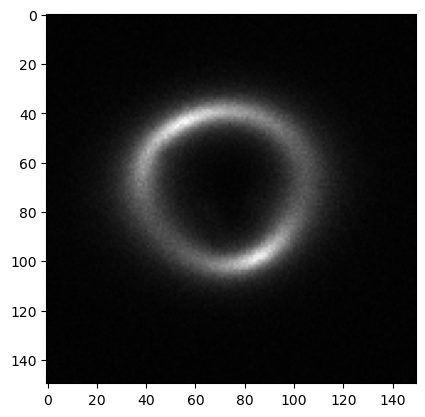

Label: 2


In [6]:
# Display image and label.
train_features, train_labels = next(iter(dataloaders['train']))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
print(img.get_device())
img = img.cpu().numpy()
label = train_labels[0]
plt.imshow(img,cmap='gray')
plt.show()
print(f"Label: {label}")

## Build Neural Network Architecture

The neural network is based on restnet50 architecture, but a convolutional layer is added in the beginning of the layer to single kernel image data. In this model, we remove the fully connected layer in restnet and replace it with sequential linear layer 

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 3)
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        # Get number of input features of the fully connected layer in restnet
        num_ftrs = self.resnet.fc.in_features
        linear_relu_stack = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )
        self.resnet.fc = linear_relu_stack

    def forward(self, x):
        x = self.conv1(x)
        x = self.resnet(x)
        return x

In [8]:
model = NeuralNetwork().to(DEVICE)
print(model)

NeuralNetwork(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu):

## Define function to training the model

For the purpose of capturing the best model's weight, we will test our training result for every epoch using validation data. then we will save the weight that has the best accuracy

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(1,num_epochs+1):
            print(f'Epoch {epoch}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                size = len(dataloaders[phase].dataset)
                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for batch, (inputs, labels) in enumerate(dataloaders[phase]):
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    current_loss = loss.item()
                    current =  batch * BATCH_SIZE + len(inputs)
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                    if batch % 100 == 0:
                        print(f"Current loss: {current_loss:>7f}  [{current:>5d}/{size:>5d}]")

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

model_ft = train_model(model, loss_fn, optimizer, exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
# torch.save(model.state_dict(), 'model_weights_resnet50_train3.pth')

## Load trained model and plot the prediction on validation dataset

In [9]:
model.load_state_dict(torch.load('model_weights_challenge1.pth'))

<All keys matched successfully>

In [10]:
def plot_model_prediction(batch_images, actual_label, predicted_label):
    num_images = batch_images.shape[0]

    # Create a grid of subplots
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(num_images):
        # Extract the image from the batch_images
        image = batch_images[i, 0]  # Assuming grayscale images
        # Plot the image
        axes[i].imshow(image, cmap='gray')  # Assuming grayscale images
        axes[i].set_title("predicted: {}, actual: {}".format(predicted_label[i],actual_label[i]))
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

idx_to_class ={i: x for (i,x) in enumerate(class_names)}

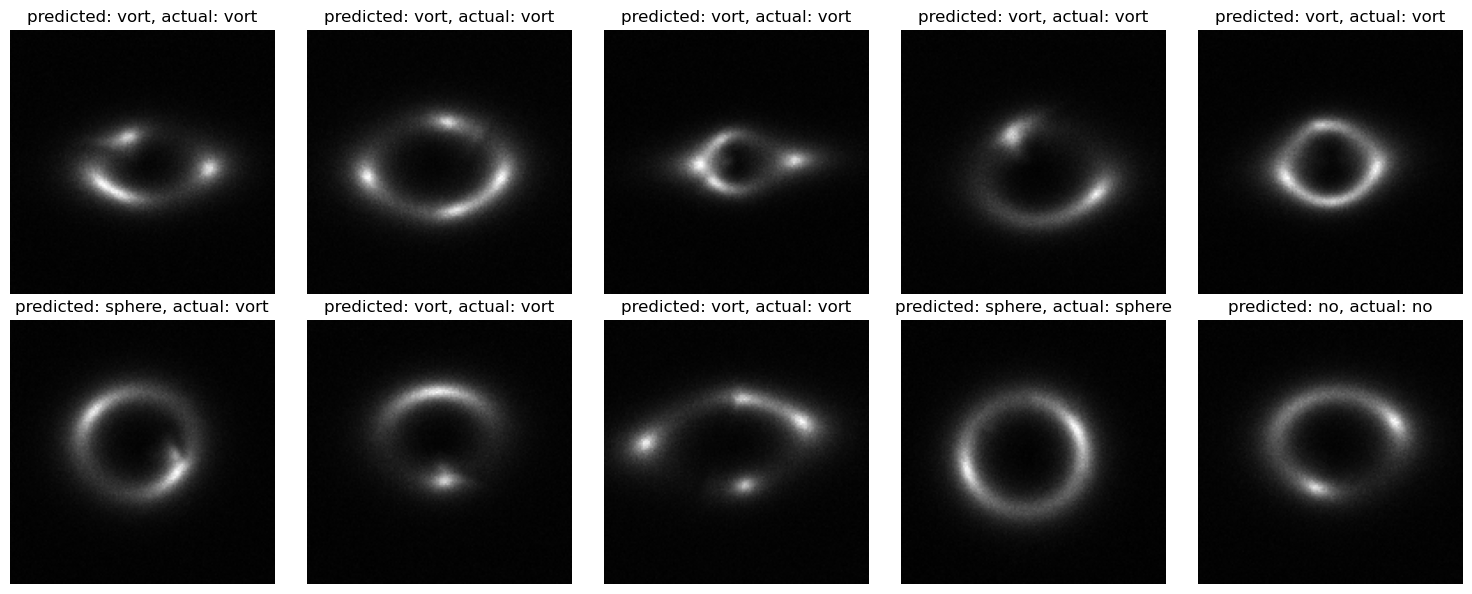

In [11]:
model.eval()
with torch.no_grad():
    inputs, label = next(iter(dataloaders['val']))
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

plot_model_prediction(inputs.cpu(),
                      [idx_to_class[idx] for idx in label.cpu().numpy()], 
                      [idx_to_class[idx] for idx in preds.cpu().numpy()])

## Plot ROC curve using validation dataset

In [12]:
actual_test_labels = []
predicted_test_labels = []
# predicted_test_raw_scores = np.empty((0, 3))
for batch, (test_data, test_label) in enumerate(dataloaders['val']):
    model.eval()
    with torch.no_grad():
        prediction_score = model(test_data)
        _, prediction_output = torch.max(prediction_score,1)
        # predicted_test_raw_scores = np.append(predicted_test_raw_scores, prediction_score.cpu().numpy(),axis=0)
        predicted_test_labels.extend(prediction_output.cpu().numpy())
    actual_test_labels.extend(test_label.cpu().numpy())

In [13]:
label_binarizer = LabelBinarizer().fit(actual_test_labels)
actual_label_onehot = label_binarizer.transform(actual_test_labels)
predicted_label_oneshot = label_binarizer.transform(predicted_test_labels)

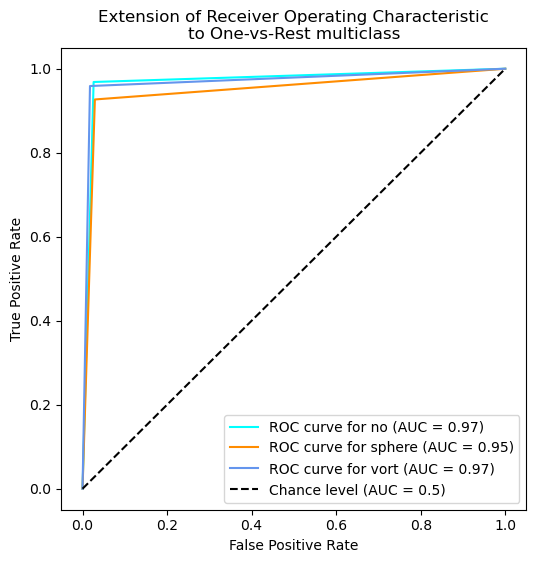

In [15]:
from itertools import cycle

from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(6, 6))
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(len(image_datasets['val'].classes)), colors):
    RocCurveDisplay.from_predictions(
        actual_label_onehot[:, class_id],
        predicted_label_oneshot[:, class_id],
        name=f"ROC curve for {image_datasets['val'].classes[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)